In [1]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [2]:
fname1 = "dataset/test_00000.jpg"
fname2 = "templates/Recycle_00041.png"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

#img1 = K.geometry.resize(img1, (600, 375), antialias=True)
# resize img1 to height = 500 while keeping the aspect ratio
width_resized = int(500 * img1.shape[3] / img1.shape[2])
img1 = K.geometry.resize(img1, (500, width_resized), antialias=True)
#img2 = K.geometry.resize(img2, (600, 375), antialias=True)

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

In [3]:
matcher = KF.LoFTR(pretrained="outdoor")

In [4]:
def get_correspondences(input_dict):
	with torch.inference_mode():
		correspondences = matcher(input_dict)
	return correspondences

In [7]:
correspondences = get_correspondences(input_dict)

In [8]:
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


In [9]:
mkpts0 = correspondences["keypoints0"].numpy()
mkpts1 = correspondences["keypoints1"].numpy()

Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

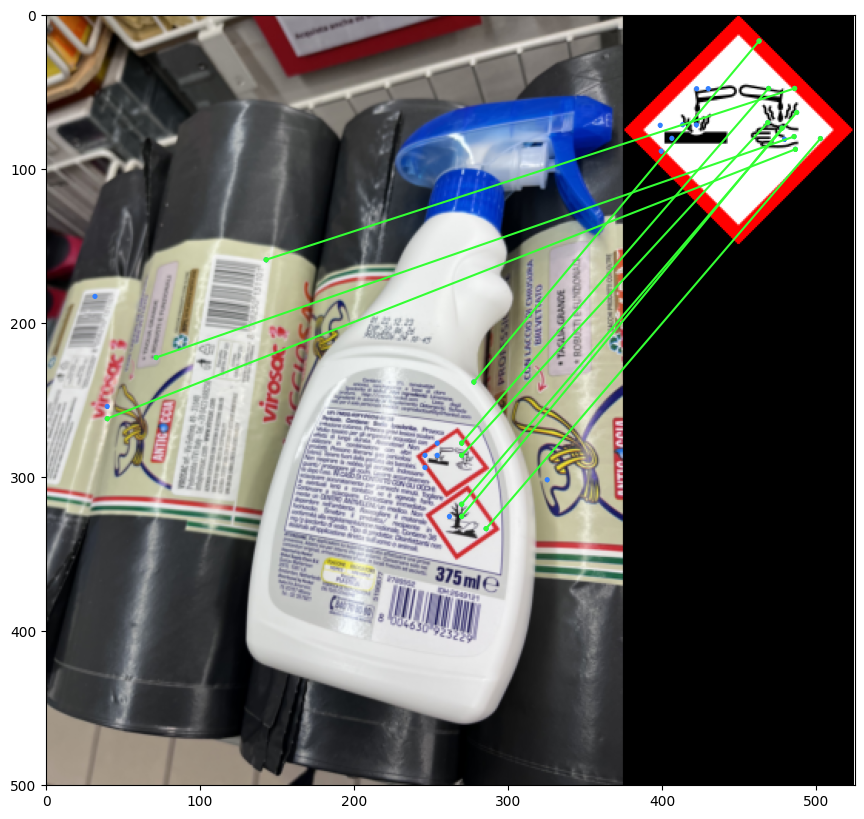

In [10]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)